## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from skopt.space import Real, Categorical, Integer
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.layers import Dense,Input,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

## Functions for calculating normalized gini coefficient

In [3]:
# https://www.kaggle.com/code/batzner/gini-coefficient-an-intuitive-explanation
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703

def gini(actual, pred):  
    
    '''Function to calculate gini coefficient given actual and predicted values'''
    
    assert( len(actual) == len(pred) )  
    all_ = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float) # Concatenate [actual_val, pred_val, index]
    
    all_ = all_[ np.lexsort((all_[:,2], -1*all_[:,1])) ]  # lexsort returns indices 
                                                          # sort first based on 2nd column, then sort based on 3rd column 
                                                          # so first sort in descending order based on predicted val
                                                          #if predicted val are equal sort based on index in ascending order
                                                             
    totalLosses = all_[:,0].sum()                         # Sum of actual values
    
    giniSum = all_[:,0].cumsum().sum() / totalLosses      # Get cumulative sum of actual values in a list like [1,2,3,4,4,5]
                                                          # then sum the list values of cumulative sum
                                                          # divide the value we get by sum of actual values
    
    giniSum -= (len(actual) + 1) / 2                      # ginisum = ginisum - ((number_of_data_points + 1)/2)
    
    return giniSum / len(actual)                          # gini_coefficient = ginisum/number_of_data_points
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient given actual and predicted values'''
    
    return (gini(a, p) / gini(a, a)) # normalized_gini = gini_coefficient_of_actual_predicter/gini_coefficient_of_actual_actual
                                     # gini_coefficient_of_actual_actual is the maximum value the gini_coefficient can have
                                     # for the given data  


 ## Functions for encoding data

In [4]:
def one_hot_encoding(train_df, test_df, features):
    '''Function to one hot encode categorical features given dataframe and feature names that need to be encoded'''
    
    ohe = OneHotEncoder(dtype = int)    
    ohe.fit(train_df[features])
    ohe_train = ohe.transform(train_df[features]).toarray()
    cols = ohe.get_feature_names_out()
    ohe_train_df = pd.DataFrame(data = ohe_train, columns = cols, index = train_df.index)
    
    dump(ohe, 'ohe.joblib')                 # Saving the one hot encoder model so that we can directly 
                                            # use it on test data
    train_df =  train_df.drop(columns=features)
    train_df = pd.concat([train_df, ohe_train_df], axis=1)

    ohe_test = ohe.transform(test_df[features]).toarray()
    ohe_test_df = pd.DataFrame(data = ohe_test, columns = cols, index = test_df.index)
    test_df =  test_df.drop(columns=features)
    test_df = pd.concat([test_df, ohe_test_df], axis=1)
    return train_df, test_df

In [5]:
def target_encoding(train_df, target, test_df,  features):
    '''Function to target encode categorical features given dataframe and feature names that need to be encoded. 
       Target encoding is the value of P(Class|category)'''
    target_enc = TargetEncoder(cols = features)
    target_enc.fit(train_df, target)
    target_encoded_train_df = target_enc.transform(train_df)
    dump(target_enc, 'target_encoding.joblib')                  # Saving target encoder model so that we can directly 
                                                                # use it on test data
    target_encoded_test_df = target_enc.transform(test_df)
    return target_encoded_train_df, target_encoded_test_df

In [6]:
def standardizing_continuous_features(train_df, test_df, features):
    '''Function to standardize numerical features given dataframe and feature names that need to be standardized'''
    scaler = StandardScaler()
    scaler.fit(train_df[features])
    train_df[features] = scaler.transform(train_df[features])
    dump(scaler, 'standard_scaler.joblib')                  # Saving Standard Scaler model so that we can directly 
                                                            # use it on test data
    test_df[features] = scaler.transform(test_df[features])
    return train_df, test_df

## Function for filling missing Values

In [7]:
def fill_missing_values(df):
    '''Function to fill missing values in a given dataframe'''
    fill_with_mode = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat','ps_car_07_cat',
                          'ps_car_09_cat']
    fill_with_mean = ['ps_car_11' , 'ps_car_12' , 'ps_car_14']
    df = df.copy()                                          # Using copy so that original dataframe values are not changed
    df['missing'] = (abs(df[df == -1].sum(axis = 1))).astype(int)   # Add a new 'missing' feature that specifies how many
                                                            # feature values were originally missing in each datapoint
    for col in fill_with_mode:
        df[col] = df[col].replace(-1,df[col].mode()[0])     # Replacing '-1' with the value that occured the most in this column
    for col in fill_with_mean:
        df[col] = df[col].replace(-1, df[col].mean())       # Replacing '-1' with the mean of the column values
    return df

## Function for oversampling and undersampling

In [8]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
def over_under_sampling(x_train, y_train):
    '''Function to oversample the minority class and undersample the majority class'''
    smote_cat_features = [col for col in x_train.columns if "cat" in str(col) or "bin" in str(col)]
    categorical_column_indices = []
    for i in range(len(x_train.columns)):
        if x_train.columns[i] in smote_cat_features:
            categorical_column_indices.append(i)
            
    # SMOTENC is used when we have a mix of Continuous and categorical features in our dataset.
    # We can specify the categorical feature indices and SMOTENC will only use valid category values for those features  
    # Here, we are oversampling minority class such that 
    # number of datapoints in minority class is 20% of number of datapoints in majority class
    sm = SMOTENC(categorical_features= categorical_column_indices, sampling_strategy = 0.2, random_state=0, n_jobs = -2)
    X_smote, Y_smote = sm.fit_resample(x_train, y_train)
    
    # Randomly undersample majority class data points 
    # Here, the number of datapoints in majority class is made to be 5 times more than number of datapoints in minority class
    # i.e. Number_of_datapints_in_majority_class = 2.5 * Number_of_datapints_in_minority_class
    under_sampler = RandomUnderSampler(sampling_strategy=0.4, random_state=0) 
                                                                              
    X_under_sampled, Y_under_sampled = under_sampler.fit_resample(X_smote, Y_smote)
    return X_under_sampled, Y_under_sampled

## Splitting target variable and input features

In [9]:
train_df = pd.read_csv('train.csv')   # Read training data

In [10]:
Y = train_df['target']
X = train_df.drop('target', axis = 1)

## Dropping unnecessary features

In [11]:
# Dropping all continuous calc features as they are not useful in classifying the target variable
continuous_calc_features = [col for col in X.columns if "calc" in col and "bin" not in col]   
X.drop(continuous_calc_features, axis = 1, inplace = True)

# Dropping feature 'id' as it is an identifier and is not useful for classifying the target variable
X.drop(['id'], axis = 1, inplace = True)

## Splitting Training and cv data

In [12]:
X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 0)

In [13]:
print('Size of train dataset:', X_train.shape, Y_train.shape)
print('Size of cv dataset:', X_cv.shape, Y_cv.shape)

Size of train dataset: (476169, 43) (476169,)
Size of cv dataset: (119043, 43) (119043,)


## Using two sets of data to compare results

We are using two sets of data with input data going through different types of featurization and data augumentation:
1. <B>Imbalanced data:</B> Fill missing values + One hot Encoding + Standardization
2. <B>Augumented data:</B> Oversampling and undersampling data augumentation + Fill missing values + Target Encoding + One hot Encoding + Standardization


We are doing this to check how the models perform with these two sets of data.

## Oversampling and undersampling to reduce the class imbalance in training data

In [14]:
X_train_aug, Y_train_aug = over_under_sampling(X_train, Y_train)
print('Number of data points in augumented train dataset:', len(X_train_aug))

Number of data points in augumented train dataset: 321167


In [15]:
y_train_imb_value_counts = Y_train.value_counts()
class_0_percentage = (np.round(y_train_imb_value_counts[0]/len(Y_train),4)) * 100
class_1_percentage = (np.round(y_train_imb_value_counts[1]/len(Y_train),4)) * 100
print('In imbalanced data:')
print('There are {} ({}%) points for class 0 and {} ({}%) points for class 1'
      .format(y_train_imb_value_counts[0], class_0_percentage, y_train_imb_value_counts[1], class_1_percentage))
                                                                                           

y_train_aug_value_counts = Y_train_aug.value_counts()
class_0_percentage = (np.round(y_train_aug_value_counts[0]/len(Y_train_aug),4)) * 100
class_1_percentage = (np.round(y_train_aug_value_counts[1]/len(Y_train_aug),4)) * 100
print('\nIn augumented data:')
print('There are {} ({}%) points for class 0 and {} ({}%) points for class 1'
      .format(y_train_aug_value_counts[0], class_0_percentage, y_train_aug_value_counts[1], class_1_percentage))

In imbalanced data:
There are 458814 (96.36%) points for class 0 and 17355 (3.64%) points for class 1

In augumented data:
There are 229405 (71.43%) points for class 0 and 91762 (28.57%) points for class 1


## Filling missing values and adding a new feature 'missing'

In [16]:
X_train_imb_filled_missing = fill_missing_values(X_train)
X_cv_imb_filled_missing = fill_missing_values(X_cv)

X_train_aug_filled_missing = fill_missing_values(X_train_aug)
X_cv_aug_filled_missing = fill_missing_values(X_cv)

## Target Encoding Categorical features

ps_car_01_cat, ps_car_04_cat, ps_car_06_cat, ps_car_11_cat features have more than 10 categories. 
So, it is better to do target encoding for them as one hot encoding will significanlty increase the dimensions of our data. 

In [17]:
target_encoding_features = ['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat']

X_train_aug_target_encoded, X_cv_aug_target_encoded = target_encoding(X_train_aug_filled_missing, 
                                            Y_train_aug, X_cv_aug_filled_missing, target_encoding_features)

## One hot encoding Categorical features

In [18]:
# Select all columns have 'cat' in their names and that are not used for target encoding
cat_features_aug = [col for col in X.columns if "cat" in str(col) and col not in target_encoding_features]
X_train_aug_ohe, X_cv_aug_ohe = one_hot_encoding(X_train_aug_target_encoded, X_cv_aug_target_encoded, cat_features_aug)

# Select all columns have 'cat' in their names
cat_features_imb = [col for col in X.columns if "cat" in str(col)]
X_train_imb_ohe, X_cv_imb_ohe = one_hot_encoding(X_train_imb_filled_missing, X_cv_imb_filled_missing, cat_features_imb)

## Scaling continuous features

In [19]:
# Select all columns which do not have 'bin' and 'cat' in their names                                                          
continuous_features = [col for col in X_train.columns if "bin" not in col and "cat" not in col ]

X_train_aug_final, X_cv_aug_final = standardizing_continuous_features(X_train_aug_ohe, X_cv_aug_ohe, continuous_features)

X_train_imb_final, X_cv_imb_final = standardizing_continuous_features(X_train_imb_ohe, X_cv_imb_ohe, continuous_features)

In [20]:
print('Size of imbalanced training dataset:', X_train_imb_final.shape, Y_train.shape)
print('Size of augumented training dataset:', X_train_aug_final.shape, Y_train_aug.shape)

Size of imbalanced training dataset: (476169, 207) (476169,)
Size of augumented training dataset: (321167, 67) (321167,)


## Function to plot confusion matrix

In [20]:
def plot_confusion_matrix(estimator, imb_or_aug_data, model_name, neural_network = None):
    ''' Function to plot confusion matrix of cv data. 
    Function call should have the arguments:
    estimator : The trained machine learning or deep learning model. In case of auto-encoder, this will be the predicted classes
    imb_or_aug_data : value should be 'imb' if using imbalanced data and 'aug' if using augumented data 
    model_name : The name of the model to display in title of the Confusion Matrix.
    neural_network : Optional argument. Value should be 'MLP' if the model is a Multi Layer Perceptron or 'AE' if it is an
                     Auto-Encoder. Otherwise, no need to use this argument'''
    
    plt.figure(figsize=(5,3)) 
    plt.title('Confusion matrix of '+ model_name +' on Cross Validation Data')
    if not neural_network:
        if imb_or_aug_data == 'imb':
            sns.heatmap(confusion_matrix(Y_cv, estimator.predict(X_cv_imb_final)), annot = True, fmt ='g')
            plt.xlabel("Predicted Class")
            plt.ylabel("True class");
        elif imb_or_aug_data == 'aug':
            sns.heatmap(confusion_matrix(Y_cv, estimator.predict(X_cv_aug_final)), annot = True, fmt ='g')
            plt.xlabel("Predicted Class")
            plt.ylabel("True class");
            
    if neural_network == 'MLP':
        if imb_or_aug_data == 'imb':
            sns.heatmap(confusion_matrix(Y_cv, estimator.predict(X_cv_imb_final)), 
                        annot = True, fmt ='g')
            plt.xlabel("Predicted Class")
            plt.ylabel("True class");
        elif imb_or_aug_data == 'aug':
            sns.heatmap(confusion_matrix(Y_cv, estimator.predict(X_cv_imb_final)),
                        annot = True, fmt ='g')
            plt.xlabel("Predicted Class")
            plt.ylabel("True class");
            
    elif neural_network == 'AE':
        predictions = estimator
        sns.heatmap(confusion_matrix(Y_cv, predictions), 
                        annot = True, fmt ='g')
        plt.xlabel("Predicted Class")
        plt.ylabel("True class");
        

## Modeling

In [21]:
# creating a scorer for custom performance metric and to use that metric for cross validation
gini_normalized_scorer = make_scorer(gini_normalized, needs_proba=True,  greater_is_better= True)  

## Logistic Regression

In [22]:
lr_parameters = {'alpha':[0.0001,0.001,0.01,0.1,0.5,1]}
lr_model = SGDClassifier(loss = 'log', random_state=0)

### Imbalanced data

In [23]:
lr_clf_imb = GridSearchCV(lr_model, lr_parameters, scoring = gini_normalized_scorer, n_jobs = -2)                  
lr_clf_imb.fit(X_train_imb_final, Y_train);

In [24]:
best_alpha_lr_imb = lr_clf_imb.best_params_['alpha']
print('Best alpha value =', best_alpha_lr_imb)
best_lr_imb = lr_clf_imb.best_estimator_
gini_lr_imb = gini_normalized(Y_cv, best_lr_imb.predict_proba(X_cv_imb_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_lr_imb)

Best alpha value = 0.001
Best normalized gini coefficient on cv data =  0.23323304199140932


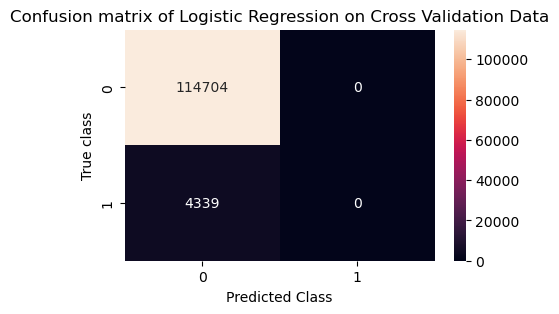

In [25]:
plot_confusion_matrix(best_lr_imb, 'imb', 'Logistic Regression')

### Augumented data

In [26]:
lr_clf_aug = GridSearchCV(lr_model, lr_parameters, scoring = gini_normalized_scorer, n_jobs = -2)
lr_clf_aug.fit(X_train_aug_final, Y_train_aug);

In [27]:
best_alpha_lr_aug = lr_clf_aug.best_params_['alpha']
print('Best alpha value =', best_alpha_lr_aug)
best_lr_aug = lr_clf_aug.best_estimator_
gini_lr_aug = gini_normalized(Y_cv, best_lr_aug.predict_proba(X_cv_aug_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_lr_aug)

Best alpha value = 0.0001
Best normalized gini coefficient on cv data =  0.04209981993674528


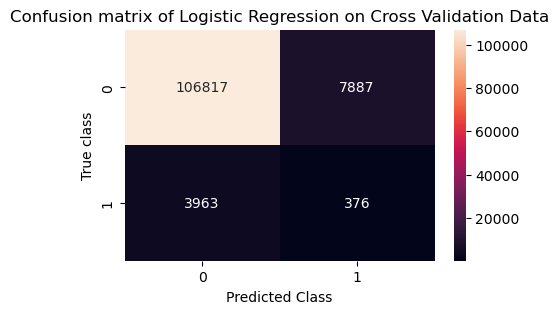

In [28]:
plot_confusion_matrix(best_lr_aug, 'aug', 'Logistic Regression')

## Decision Trees

In [29]:
params_dt ={'max_depth': Integer(1, 32), 'min_samples_split': Integer(500,3000)}
dt_model = DecisionTreeClassifier(random_state=0) 

### Imbalanced data

In [31]:
# Using BayesSearchCV as using GridSearch with multiple parameters takes too long to find correct hyperparameters
dt_clf_imb = BayesSearchCV(dt_model, params_dt, scoring = gini_normalized_scorer, n_iter = 20,  random_state = 0, n_jobs = -2)
dt_clf_imb.fit(X_train_imb_final, Y_train);

In [32]:
print('Best max depth = ',dt_clf_imb.best_params_['max_depth'])
print('Best min samples split = ',dt_clf_imb.best_params_['min_samples_split'])
best_dt_imb = DecisionTreeClassifier(random_state=0, 
                                     **dt_clf_imb.best_params_)    # Using the best parameters found by BayesSearchCV
# Using calibratedclassifier to get accurate probability predictions
calib_dt_imb = CalibratedClassifierCV(best_dt_imb, method = 'isotonic', n_jobs = -2)   
calib_dt_imb.fit(X_train_imb_final, Y_train)
gini_dt_imb = gini_normalized(Y_cv, calib_dt_imb.predict_proba(X_cv_imb_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_dt_imb)

Best max depth =  9
Best min samples split =  2947
Best normalized gini coefficient on cv data =  0.2259164834213119


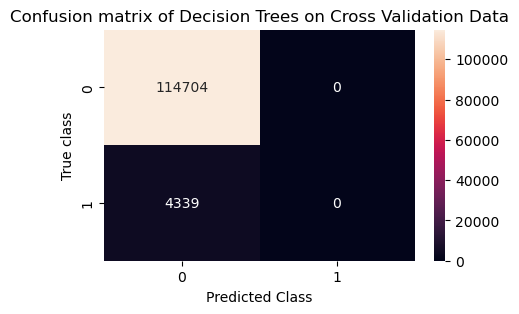

In [33]:
plot_confusion_matrix(calib_dt_imb, 'imb', 'Decision Trees')

### Augumented data

In [34]:
# Using BayesSearchCV as using GridSearch with multiple parameters takes too long to find correct hyperparameters
dt_clf_aug = BayesSearchCV(dt_model, params_dt, scoring = gini_normalized_scorer, n_iter = 20,  random_state = 0, n_jobs = -1)
dt_clf_aug.fit(X_train_aug_final, Y_train_aug);

In [35]:
print('Best max depth = ',dt_clf_aug.best_params_['max_depth'])
print('Best min samples split = ',dt_clf_aug.best_params_['min_samples_split'])
best_dt_aug = DecisionTreeClassifier(random_state=0, 
                                     **dt_clf_aug.best_params_)    # Using the best parameters found by BayesSearchCV

# Using calibratedclassifier to get accurate probability predictions
calib_dt_aug = CalibratedClassifierCV(best_dt_aug, method = 'isotonic', n_jobs = -2)   
calib_dt_aug.fit(X_train_aug_final, Y_train_aug)
gini_dt_aug = gini_normalized(Y_cv, calib_dt_aug.predict_proba(X_cv_aug_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_dt_aug)

Best max depth =  19
Best min samples split =  500
Best normalized gini coefficient on cv data =  0.15005638248545938


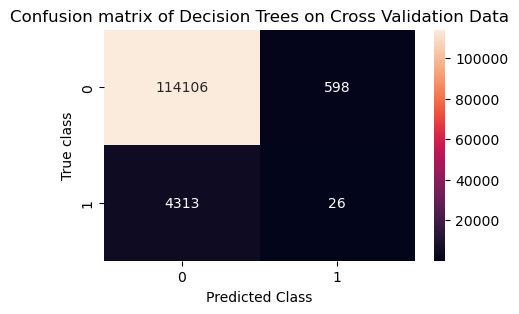

In [36]:
plot_confusion_matrix(calib_dt_aug, 'aug', 'Decision Trees')

## Random Forest

In [39]:
params_rf ={'n_estimators':Integer(100, 500), 'min_samples_split': Integer(500, 3000) }   
rf_model = RandomForestClassifier(random_state=0) 

### Imbalanced data

In [40]:
rf_clf_imb = BayesSearchCV(rf_model, params_rf, scoring = gini_normalized_scorer, n_iter = 20,  random_state = 0, n_jobs = -1)
rf_clf_imb.fit(X_train_imb_final, Y_train);

In [41]:
print('Best n_estimators value = ',rf_clf_imb.best_params_['n_estimators'])
print('Best min samples split value = ',rf_clf_imb.best_params_['min_samples_split'])
best_rf_imb = RandomForestClassifier(random_state=0,
                                    **rf_clf_imb.best_params_)           # Using the best parameters found by BayesSearchCV
calib_rf_imb = CalibratedClassifierCV(best_rf_imb, method = 'isotonic', n_jobs = -1)  
calib_rf_imb.fit(X_train_imb_final, Y_train)
gini_rf_imb = gini_normalized(Y_cv, calib_rf_imb.predict_proba(X_cv_imb_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_rf_imb)

Best n_estimators value =  413
Best min samples split value =  869
Best normalized gini coefficient on cv data =  0.25418277527847993


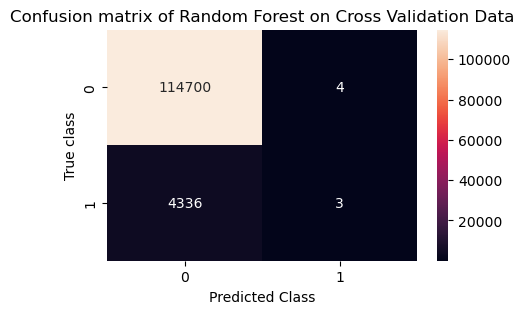

In [44]:
plot_confusion_matrix(calib_rf_imb, 'imb', 'Random Forest')

### Augumented data

In [45]:
rf_clf_aug = BayesSearchCV(rf_model, params_rf, scoring = gini_normalized_scorer, n_iter = 20,  random_state = 0, n_jobs = -1)
rf_clf_aug.fit(X_train_aug_final, Y_train_aug);

In [46]:
print('Best n_estimators value = ',rf_clf_aug.best_params_['n_estimators'])
print('Best min samples split value = ',rf_clf_aug.best_params_['min_samples_split'])
best_rf_aug = RandomForestClassifier(random_state=0, n_jobs = -1,
                                    **rf_clf_aug.best_params_)           # Using the best parameters found by BayesSearchCV
calib_rf_aug = CalibratedClassifierCV(best_rf_aug, method = 'isotonic', n_jobs = -2)  
calib_rf_aug.fit(X_train_aug_final, Y_train_aug)
gini_rf_aug = gini_normalized(Y_cv, calib_rf_aug.predict_proba(X_cv_aug_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_rf_aug)

Best n_estimators value =  500
Best min samples split value =  500
Best normalized gini coefficient on cv data =  0.11788446587862242


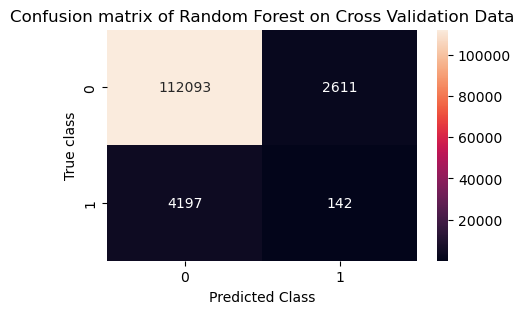

In [47]:
plot_confusion_matrix(calib_rf_aug, 'aug', 'Random Forest')

## LightGBM

In [48]:
params_lightgbm_imb ={'n_estimators':Integer(500,1500), 'learning_rate': Real(0.001,1), 'num_leaves': Integer(2,50),
                 'colsample_bytree': Real(0.5,1.0), 'reg_alpha':Real(0,1), 'reg_lambda': Real(0,1), 'subsample': Real(0.5,1), 
                 'subsample_freq': Integer(1,10)}   
lightgbm_model = LGBMClassifier(random_state=0, n_jobs = -1) 

### Imbalanced data

In [49]:
# Running a high number of iterations as there are many hyperparameters to tune
lightgbm_clf_imb = BayesSearchCV(lightgbm_model, params_lightgbm_imb, scoring = gini_normalized_scorer,n_iter = 100,
                             random_state = 0, n_jobs = -1, cv = 5)
lightgbm_clf_imb.fit(X_train_imb_final, Y_train);

In [50]:
for feature, value in lightgbm_clf_imb.best_params_.items():
    print('Best ', feature, ' = ', value)

Best  colsample_bytree  =  1.0
Best  learning_rate  =  0.01725887623364422
Best  n_estimators  =  942
Best  num_leaves  =  22
Best  reg_alpha  =  0.47837149965169523
Best  reg_lambda  =  1.0
Best  subsample  =  0.5138056793273261
Best  subsample_freq  =  1


In [51]:
best_lightgbm_imb = LGBMClassifier(random_state=0, n_jobs = -1,
                                    **lightgbm_clf_imb.best_params_)        # Using the best parameters found by BayesSearchCV
calib_lightgbm_imb = CalibratedClassifierCV(best_lightgbm_imb, method = 'isotonic', n_jobs = -1)  
calib_lightgbm_imb.fit(X_train_imb_final, Y_train)
gini_lightgbm_imb = gini_normalized(Y_cv, calib_lightgbm_imb.predict_proba(X_cv_imb_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_lightgbm_imb)

Best normalized gini coefficient on cv data =  0.2691784436788044


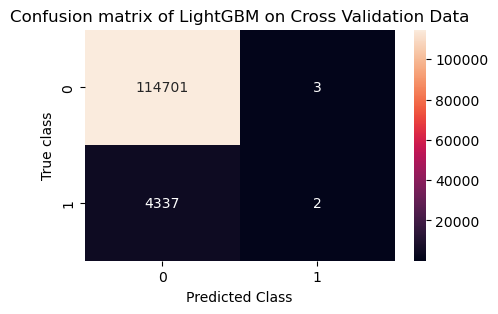

In [52]:
plot_confusion_matrix(calib_lightgbm_imb, 'imb', 'LightGBM')

### Augumented data

In [53]:
params_lightgbm_aug ={'n_estimators':Integer(100,800), 'learning_rate': Real(0.001,1), 'num_leaves': Integer(2,50),
                 'colsample_bytree': Real(0.5,1.0), 'reg_alpha':Real(0,1), 'reg_lambda': Real(0,1), 'subsample': Real(0.5,1), 
                 'subsample_freq': Integer(1,10)}    
lightgbm_model = LGBMClassifier(random_state=0, n_jobs = -1) 

In [54]:
lightgbm_clf_aug = BayesSearchCV(lightgbm_model, params_lightgbm_aug, scoring = gini_normalized_scorer,n_iter = 100,
                             random_state = 0, n_jobs = -1, cv = 5)
lightgbm_clf_aug.fit(X_train_aug_final, Y_train_aug);

In [59]:
for feature, value in lightgbm_clf_aug.best_params_.items():
    print('Best', feature, ' = ', value)

Best colsample_bytree  =  0.6677639117470856
Best learning_rate  =  0.10719988367930924
Best n_estimators  =  796
Best num_leaves  =  50
Best reg_alpha  =  0.46158698872804055
Best reg_lambda  =  0.9358508909555021
Best subsample  =  1.0
Best subsample_freq  =  4


In [56]:
best_lightgbm_aug = LGBMClassifier(random_state=0, n_jobs = -1,
                                    **lightgbm_clf_aug.best_params_)     # Using the best parameters found by BayesSearchCV
calib_lightgbm_aug = CalibratedClassifierCV(best_lightgbm_aug, method = 'isotonic', n_jobs = -1)  
calib_lightgbm_aug.fit(X_train_aug_final, Y_train_aug)
gini_lightgbm_aug = gini_normalized(Y_cv, calib_lightgbm_aug.predict_proba(X_cv_aug_final)[:,1])
print('Best normalized gini coefficient on cv data = ', gini_lightgbm_aug)

Best normalized gini coefficient on cv data =  0.08386907571204813


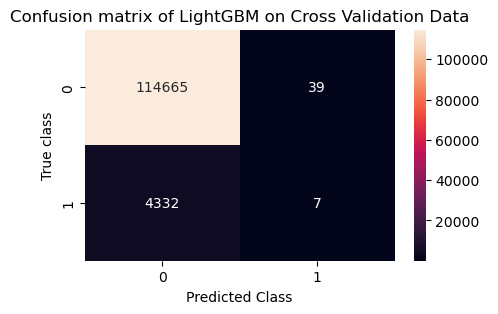

In [57]:
plot_confusion_matrix(calib_lightgbm_aug, 'aug', 'LightGBM')

### Storing all models

In [ ]:
# Dumping all the models so that we can reuse them when needed
'''
dump(best_lr_imb, 'best_lr_imb.joblib')
dump(best_lr_aug, 'best_lr_aug.joblib')
dump(best_dt_imb, 'best_dt_imb.joblib')
dump(best_dt_aug, 'best_dt_aug.joblib')
dump(best_rf_imb, 'best_rf_imb.joblib')
dump(best_rf_aug, 'best_rf_aug.joblib')
dump(best_lightgbm_imb, 'best_lightgbm_imb.joblib')
dump(best_lightgbm_aug, 'best_lightgbm_aug.joblib')

dump(calib_dt_imb, 'calib_dt_imb.joblib')
dump(calib_dt_aug, 'calib_dt_aug.joblib')
dump(calib_rf_imb, 'calib_rf_imb.joblib')
dump(calib_rf_aug, 'calib_rf_aug.joblib')
dump(calib_lightgbm_imb, 'calib_lightgbm_imb.joblib')
dump(calib_lightgbm_aug, 'calib_lightgbm_aug.joblib')'''

## Summary for Machine Learning Models

In [68]:
# http://zetcode.com/python/prettytable/

result_table = PrettyTable()
result_table.field_names = ["Data", "Model", "Normalized Gini Coefficient"]

result_table.add_row(["Imbalanced", "Logistic Regression", np.round(gini_lr_imb,4)]) 
result_table.add_row(["Imbalanced", "Decision Trees",  np.round(gini_dt_imb,4)])
result_table.add_row(["Imbalanced", "Random Forest", np.round(gini_rf_imb,4)])
result_table.add_row(["Imbalanced", "LightGBM", np.round(gini_lightgbm_imb,4)])

result_table.add_row(["Augumented", "Logistic Regression", np.round(gini_lr_aug,4)]) 
result_table.add_row(["Augumented", "Decision Trees", np.round(gini_dt_aug,4)])
result_table.add_row(["Augumented", "Random Forest", np.round(gini_rf_aug,4)])
result_table.add_row(["Augumented", "LightGBM", np.round(gini_lightgbm_aug,4)])
                      
                      
print(result_table)

+------------+---------------------+-----------------------------+
|    Data    |        Model        | Normalized Gini Coefficient |
+------------+---------------------+-----------------------------+
| Imbalanced | Logistic Regression |            0.2328           |
| Imbalanced |    Decision Trees   |            0.2259           |
| Imbalanced |    Random Forest    |            0.2542           |
| Imbalanced |       LightGBM      |            0.2692           |
| Augumented | Logistic Regression |            0.0421           |
| Augumented |    Decision Trees   |            0.1501           |
| Augumented |    Random Forest    |            0.1179           |
| Augumented |       LightGBM      |            0.0839           |
+------------+---------------------+-----------------------------+


### Observations:
1. From the above table, we can see that the Normalized Gini Coefficient is higher when we train our model using the Imbalanced data compared to Augumented data. So, it is better to not do oversampling for this dataset. <Br>
2. LightGBM gives the highest Normalized Gini Coefficient of 0.2692.

## LightGBM Feature Importance

Since the best Machine Learning model in our case is LightGBM, we can plot the feature importance of all features for this model. <Br>
Feature importance is a measure of how much a feature helps in classifying a data point.


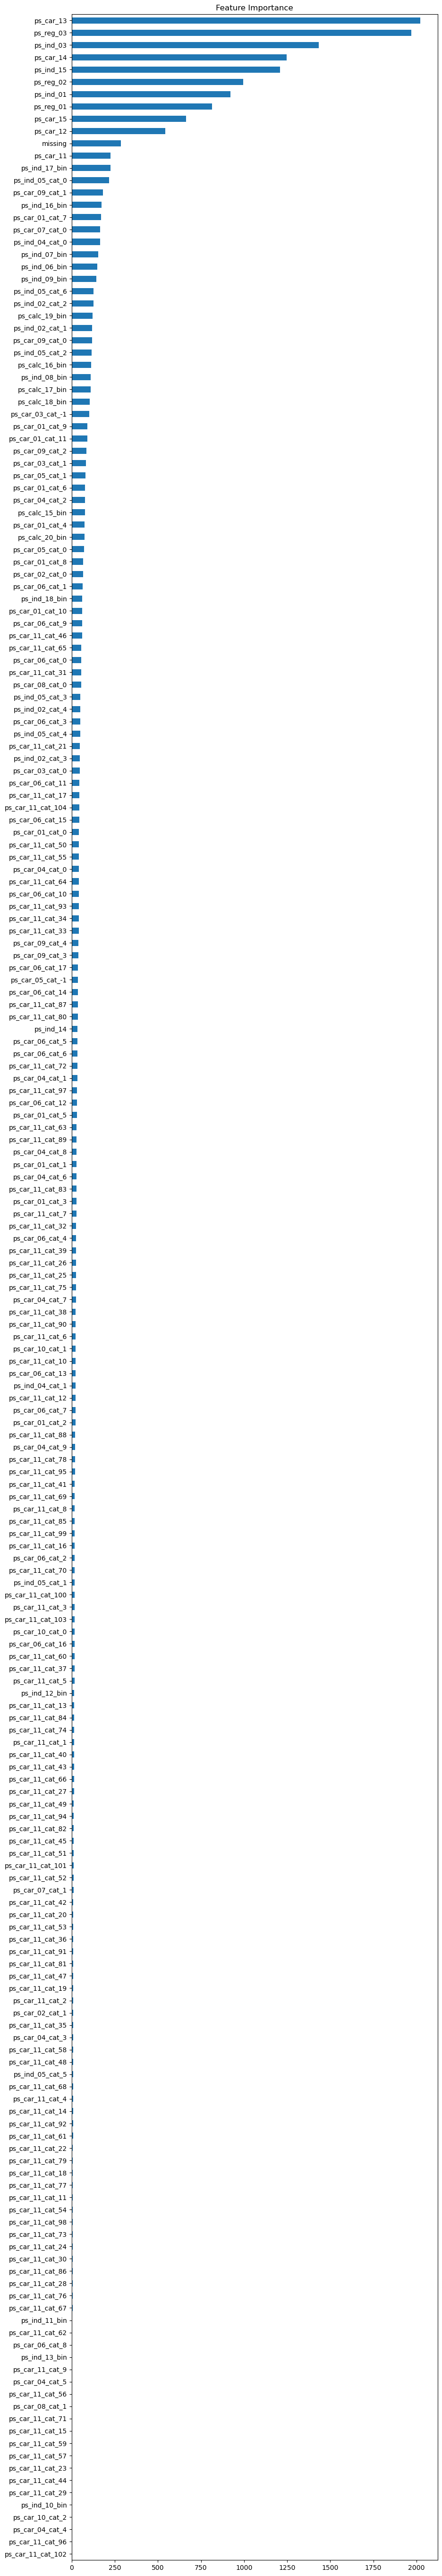

In [24]:
feat_importances = pd.Series(best_lightgbm_imb.feature_importances_, index=X_train_imb_final.columns)
feat_importances.sort_values(inplace = True)
plt.figure(figsize=(10,70))
plt.title('Feature Importance')
feat_importances.plot(kind='barh');

### Observations:
1. From the above plot, we can see that the top 5 most important feature are <Br>
    &emsp; a) ps_car_13, <Br>
    &emsp; b) ps_reg_03, <Br>
    &emsp; c) ps_ind_03, <Br>
    &emsp; d) ps_car_14, <Br>
    &emsp; e) ps_ind_15 <Br>
   The above features help LightGBM the most in classifying the datapoints.
2. The feature that we created named 'missing' is also one of the top most important features
3. The least important features are <Br>
    &emsp; a) ps_car_11_cat_102, <Br>
    &emsp; b) ps_car_11_cat_96, <Br>
    &emsp; c) ps_car_04_cat_4,<Br>
    &emsp; d) ps_car_10_cat_2, <Br>
    &emsp; e) ps_ind_10_bin <Br>
   The above features can be removed and it will not have much effect LightGBM performance. <Br>
   We can remove some of the least important features if necessary.

## Multi Layer Perceptron

In [21]:
# Defining neural network architecture
tf.keras.backend.clear_session()
relu_initializer = tf.keras.initializers.HeUniform(seed = 0)
sigmoid_initializer = tf.keras.initializers.GlorotNormal(seed = 0)

input_layer = Input(shape=(207,))          # We have 207 features for input
layer1 = Dense(128,activation='relu',kernel_initializer=relu_initializer)(input_layer)
layer2 = Dense(256,activation='relu',kernel_initializer=relu_initializer)(layer1)
layer3 = Dense(512,activation='relu',kernel_initializer=relu_initializer)(layer2)
layer4 = Dense(256,activation='relu',kernel_initializer=relu_initializer)(layer3)
layer5 = Dense(128,activation='relu',kernel_initializer=relu_initializer)(layer4)
layer6 = Dense(32,activation='relu',kernel_initializer=relu_initializer)(layer5)
layer7 = Dense(16,activation='relu',kernel_initializer=relu_initializer)(layer6)
layer8 = Dense(4,activation='relu',kernel_initializer=relu_initializer)(layer7)
output = Dense(1,activation='sigmoid',kernel_initializer= sigmoid_initializer)(layer8)

mlp_model = Model(inputs=input_layer,outputs=output)
mlp_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 207)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               26624     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128  

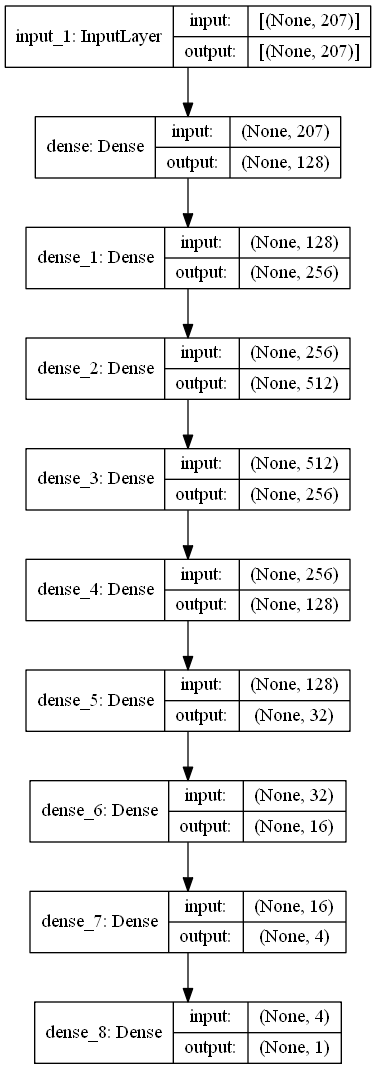

In [27]:
plot_model(mlp_model, show_shapes = True)

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= ("logs/fits/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) \
                       ,histogram_freq=1,write_graph=True)

# Using AUC value to monitor as AUC and normalized gini coefficient are related and AUC is a metric already present in Keras
# The relation can be expressed as normalized_gini_coefficient = (2 * AUC) - 1
# So, as AUC increases, normalized gini coefficient also increases.
earlystop = EarlyStopping(monitor= 'val_auc', min_delta=0.001, patience=3, verbose=1, mode = 'max')

mlp_model_filepath="model_save/best_mlp_model.hdf5"
checkpoint = ModelCheckpoint(filepath=mlp_model_filepath, monitor= 'val_auc',  verbose=1, save_best_only=True, mode='max')

call_back_list = [earlystop, checkpoint, tensorboard_callback]


In [33]:
optim_adam =  tf.keras.optimizers.Adam()
mlp_model.compile(optimizer= optim_adam, loss='binary_crossentropy', metrics= tf.keras.metrics.AUC())

mlp_model.fit(X_train_imb_final, Y_train, epochs=10, batch_size=512, validation_data=(X_cv_imb_final,Y_cv),
                          callbacks=[call_back_list])

Epoch 1/10
931/931 [==============================] - 9s 9ms/step - loss: 0.1572 - auc: 0.6053 - val_loss: 0.1539 - val_auc: 0.6194

Epoch 00001: val_auc improved from -inf to 0.61938, saving model to model_save\best_mlp_model.hdf5
Epoch 2/10
931/931 [==============================] - 7s 8ms/step - loss: 0.1528 - auc: 0.6289 - val_loss: 0.1578 - val_auc: 0.6170

Epoch 00002: val_auc did not improve from 0.61938
Epoch 3/10
931/931 [==============================] - 7s 7ms/step - loss: 0.1519 - auc: 0.6396 - val_loss: 0.1537 - val_auc: 0.6220

Epoch 00003: val_auc improved from 0.61938 to 0.62201, saving model to model_save\best_mlp_model.hdf5
Epoch 4/10
931/931 [==============================] - 6s 7ms/step - loss: 0.1509 - auc: 0.6525 - val_loss: 0.1561 - val_auc: 0.6165

Epoch 00004: val_auc did not improve from 0.62201
Epoch 5/10
931/931 [==============================] - 7s 7ms/step - loss: 0.1500 - auc: 0.6635 - val_loss: 0.1544 - val_auc: 0.6167

Epoch 00005: val_auc did not impro

In [34]:
best_mlp_model = tf.keras.models.load_model(mlp_model_filepath)
print('Best normalized gini coefficient on cv data = ', gini_normalized(Y_cv, best_mlp_model.predict(X_cv_imb_final)))

Best normalized gini coefficient on cv data =  0.24544040383985358


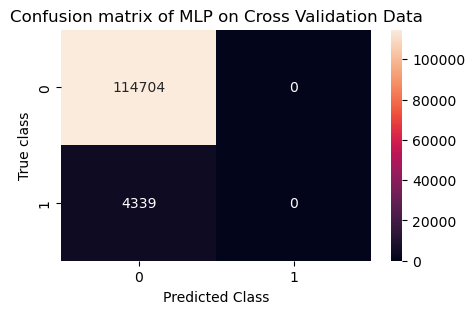

In [51]:
plot_confusion_matrix(best_mlp_model, 'imb', 'MLP', neural_network = 'MLP')

The normalized gini coefficient obtained using Multi Layer Perceptron is lower than the value we got using LightGBM. So, we can use LightGBM as the final model.

## Auto encoder

Auto-Encoder is a special type of neural network that is used for dimensionality reduction, denoising data and anomaly detection. We can approach our current probelm as an anomaly detection problem, since class 1 accounts for only 3.64% of our entire dataset. We can consider class 1 as an anomaly and class 0 as the normal data. <Br>
    
An auto-Encoder model first encodes the input into a smaller dimension and then decodes (reconstructs) it back to the original data. So, the input and output of an auto-encoder should be equal. <Br>

We train all class 0 data using auto encoder so that the model can reconstruct class 0 data very well with minimal loss. Now, when we use class 1 data, it will not be able to reconstruct the data very well and so it will have high loss. We classify all the data that has high reconstruction loss as class 1 data and  the rest of data as class 0 data. <Br>
    
<B>Note</B>: Auto-encoder model does not give a probabilistic output as we are classifying based on reconstruction loss. So, we won't be able to use Normalized Gini Coefficient as it needs probability values for calculation.

### Separating class 0 data

In [21]:
# Getting indices of class 0 and class 1 data
class_0_index_train = Y_train[Y_train == 0].index     

class_0_index_cv = Y_cv[Y_cv == 0].index

# Separately storing class 0 train and cv data
X_train_imb_final_class_0 = np.asarray(X_train_imb_final.loc[class_0_index_train])   

X_cv_imb_final_class_0 = np.asarray(X_cv_imb_final.loc[class_0_index_cv])   

# Combining class 0 train and cv data
class_0_data = np.vstack((X_train_imb_final_class_0, X_cv_imb_final_class_0))

In [51]:
tf.keras.backend.clear_session()
relu_initializer = tf.keras.initializers.HeUniform(seed = 0)
sigmoid_initializer = tf.keras.initializers.GlorotNormal(seed = 0)

# Defining the encoder architecture
input_layer = Input(shape=(207,))
encoded = Dense(128, activation='relu', kernel_initializer = relu_initializer)(input_layer)
encoded = Dense(64, activation='relu', kernel_initializer = relu_initializer)(encoded)
encoded = Dense(32, activation='relu', kernel_initializer = relu_initializer)(encoded)

# Defining the decoder architecture
decoded = Dense(64, activation='relu', kernel_initializer = relu_initializer)(encoded)
decoded = Dense(128, activation='relu', kernel_initializer = relu_initializer)(decoded)
decoded = Dense(207, activation='sigmoid', kernel_initializer = sigmoid_initializer)(decoded)

# Defining the autoencoder as a Keras model
autoencoder = Model(input_layer, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 207)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               26624     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 207)               26703 

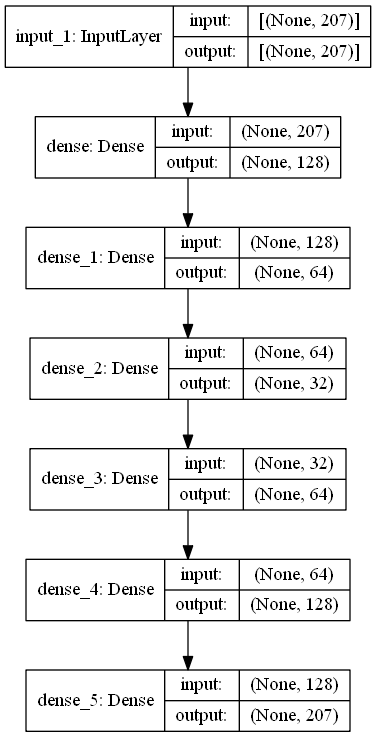

In [52]:
plot_model(autoencoder, show_shapes = True)

In [53]:
mlp_ae_filepath="model_save/best_autoencoder_model.hdf5"
checkpoint = ModelCheckpoint(filepath=mlp_ae_filepath, monitor= 'loss',  verbose=1, save_best_only=True, mode='min')

In [54]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder on your dataset
# Using X_train_imb_final_class_0 as input and target. X_train_imb_final_class_0 will be encoded first and needs to
# be decoded such that we get back the value of X_train_imb_final_class_0
autoencoder.fit(class_0_data, class_0_data, epochs=20, batch_size=128,
               callbacks= checkpoint)

Epoch 1/20
4481/4481 [==============================] - 17s 3ms/step - loss: 0.0614

Epoch 00001: loss improved from inf to 0.06141, saving model to model_save\best_autoencoder_model.hdf5
Epoch 2/20
4481/4481 [==============================] - 17s 4ms/step - loss: 0.0563

Epoch 00002: loss improved from 0.06141 to 0.05631, saving model to model_save\best_autoencoder_model.hdf5
Epoch 3/20
4481/4481 [==============================] - 16s 4ms/step - loss: 0.0557

Epoch 00003: loss improved from 0.05631 to 0.05568, saving model to model_save\best_autoencoder_model.hdf5
Epoch 4/20
4481/4481 [==============================] - 16s 4ms/step - loss: 0.0561

Epoch 00004: loss did not improve from 0.05568
Epoch 5/20
4481/4481 [==============================] - 16s 4ms/step - loss: 0.0561

Epoch 00005: loss did not improve from 0.05568
Epoch 6/20
4481/4481 [==============================] - 16s 4ms/step - loss: 0.0560

Epoch 00006: loss did not improve from 0.05568
Epoch 7/20
4481/4481 [==========

In [26]:
mlp_ae_filepath="model_save/best_autoencoder_model.hdf5"
best_autoencoder_model = tf.keras.models.load_model(mlp_ae_filepath)

In [27]:
reconstructions_train = best_autoencoder_model.predict(class_0_data, batch_size = 128)

In [28]:
train_loss = tf.keras.losses.mse(class_0_data, reconstructions_train)
threshold = np.mean(train_loss) + np.std(train_loss)

In [29]:
# Trying to reconstruct the cv data
reconstructions_test = best_autoencoder_model.predict(np.asarray(X_cv_imb_final), batch_size = 128)

In [31]:
test_loss = tf.keras.losses.mse(X_cv_imb_final, reconstructions_test)

In [33]:
# Detect anomalies which have higer loss than the threshold value
anomalies = (test_loss > threshold)
ae_predictions = np.asarray(anomalies).astype('int')

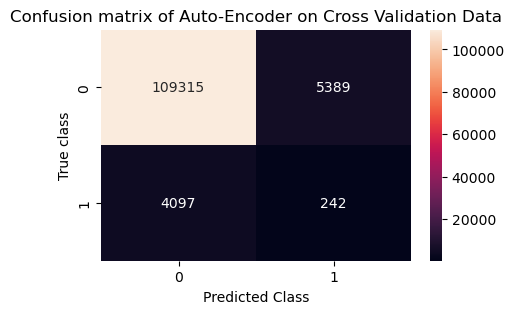

In [34]:
plot_confusion_matrix(ae_predictions, 'imb', 'Auto-Encoder', 'AE')

Even though this simple auto-encoder is able to detect many of the class 1 data, it also makes a lot of mistakes in classifying the class 0 data.

### Summary:
Based on results obtained using all the above models, the best normalized Gini Coefficient is obtained using LightGBM. <Br>
    So, we can use LightGBM as our final model.